In [1]:
import os.path as op
import scipy.io
import numpy as np
import mne
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
from mne.channels import find_ch_adjacency
from mne.stats import permutation_cluster_1samp_test, ttest_1samp_no_p
from functools import partial

In [22]:
pipeline='NEARICA'
ages=['9m','12m','adult']
c_cluster_chans=['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51']
p_cluster_chans=['E26', 'E27','E28', 'E31', 'E40','E42', 'E45', 'E46']


montage = mne.channels.make_standard_montage('GSN-HydroCel-64_1.0')
info = mne.create_info(montage.ch_names, 1000, 'eeg').set_montage(montage)

_channels = np.array([np.where(np.in1d(info.ch_names, ch))[0] for ch in c_cluster_chans])
c_mask = np.zeros(len(montage.ch_names), dtype='bool')
c_mask[_channels]=True

_channels = np.array([np.where(np.in1d(info.ch_names, ch))[0] for ch in p_cluster_chans])
p_mask = np.zeros(len(montage.ch_names), dtype='bool')
p_mask[_channels]=True

plags=[2, 3, 4]


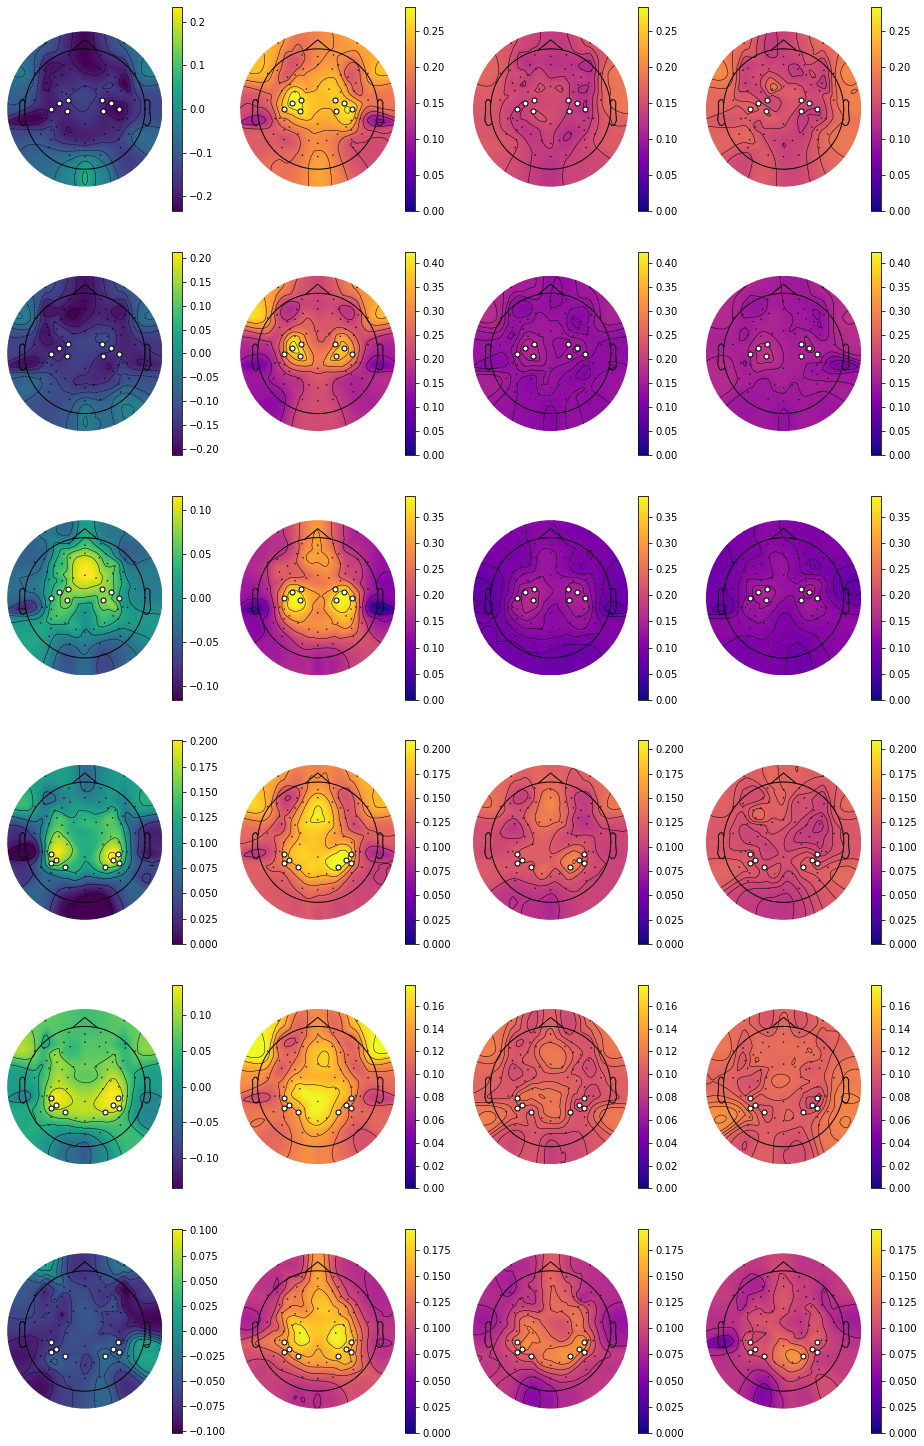

In [25]:
fig=plt.figure(figsize=(16,24), facecolor='w')
gs = fig.add_gridspec(len(ages)*2,4)

for age_idx, age in enumerate(ages):
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_C_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    beta1_idx=np.where(ranges[:,1]<=30)[0][-1]
    beta1_range=ranges[beta1_idx,:]    
        
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_P_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    beta2_idx=np.where(ranges[:,1]<=30)[0][-1]+1
    beta2_range=ranges[beta2_idx,:]    

    # Load PSD
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    periodic=f['periodic']
    frex=f['frex']
    
    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    lags=f['lags'][0,:]
    lagged_coh=f['lagged_coh']
    freq_idx=np.where((foi>=5) & (foi<=80))[0]
    foi=foi[freq_idx]
    lag_idx=np.where((lags<=4.5))[0]
    lags=lags[lag_idx]
    lagged_coh=lagged_coh[:,:,freq_idx,:]
    lagged_coh=lagged_coh[:,:,:,lag_idx]
    for s in range(lagged_coh.shape[0]):
        subj_lagged_coh=lagged_coh[s,:,:,:]
        lagged_coh[s,:,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])
    
    ax = fig.add_subplot(gs[age_idx, 0])
    frex_idx=np.where((frex>=beta1_range[0]) & (frex<=beta1_range[1]))[0]
    mean_beta=np.mean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)    
    tm,cm=plot_topomap(mean_beta,info,cmap='viridis',axes=ax,show=False,
                       mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
    plt.colorbar(tm)
    
    foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
    for l in range(len(plags)):
        lag_idx=np.where((lags>=plags[l]) & (lags<=(plags[l]+.5)))[0]
        foi_idx=np.where((foi>=beta1_range[0]) & (foi<=beta1_range[1]))[0]
        flc=lagged_coh[:,:,foi_idx,:]
        flc=flc[:,:,:,lag_idx]
        flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
        foi_lc[:,l,:]=flc
    mean_foi_lc=np.nanmean(foi_lc,axis=0)
        
    max_lc=np.max(mean_foi_lc[:])
    for l in range(len(plags)):
        ax = fig.add_subplot(gs[age_idx, l+1])
        tm,cm=plot_topomap(mean_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=0, vmax=max_lc,
                           mask=c_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
        plt.colorbar(tm)
        
    
    ax = fig.add_subplot(gs[len(ages)+age_idx, 0])
    frex_idx=np.where((frex>=beta2_range[0]) & (frex<=beta2_range[1]))[0]
    mean_beta=np.mean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)    
    tm,cm=plot_topomap(mean_beta,info,cmap='viridis',axes=ax,show=False,
                       mask=p_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
    plt.colorbar(tm)

    foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
    for l in range(len(plags)):
        lag_idx=np.where((lags>=plags[l]) & (lags<=(plags[l]+.5)))[0]
        foi_idx=np.where((foi>=beta2_range[0]) & (foi<=beta2_range[1]))[0]
        flc=lagged_coh[:,:,foi_idx,:]
        flc=flc[:,:,:,lag_idx]
        flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
        foi_lc[:,l,:]=flc
    mean_foi_lc=np.nanmean(foi_lc,axis=0)

    max_lc=np.max(mean_foi_lc[:])
    for l in range(len(plags)):
        ax = fig.add_subplot(gs[len(ages)+age_idx, l+1])
        tm,cm=plot_topomap(mean_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=0, vmax=max_lc,
                           mask=p_mask,mask_params=dict(markersize=5, markerfacecolor='w'))
        plt.colorbar(tm)

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure2.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure2.png')


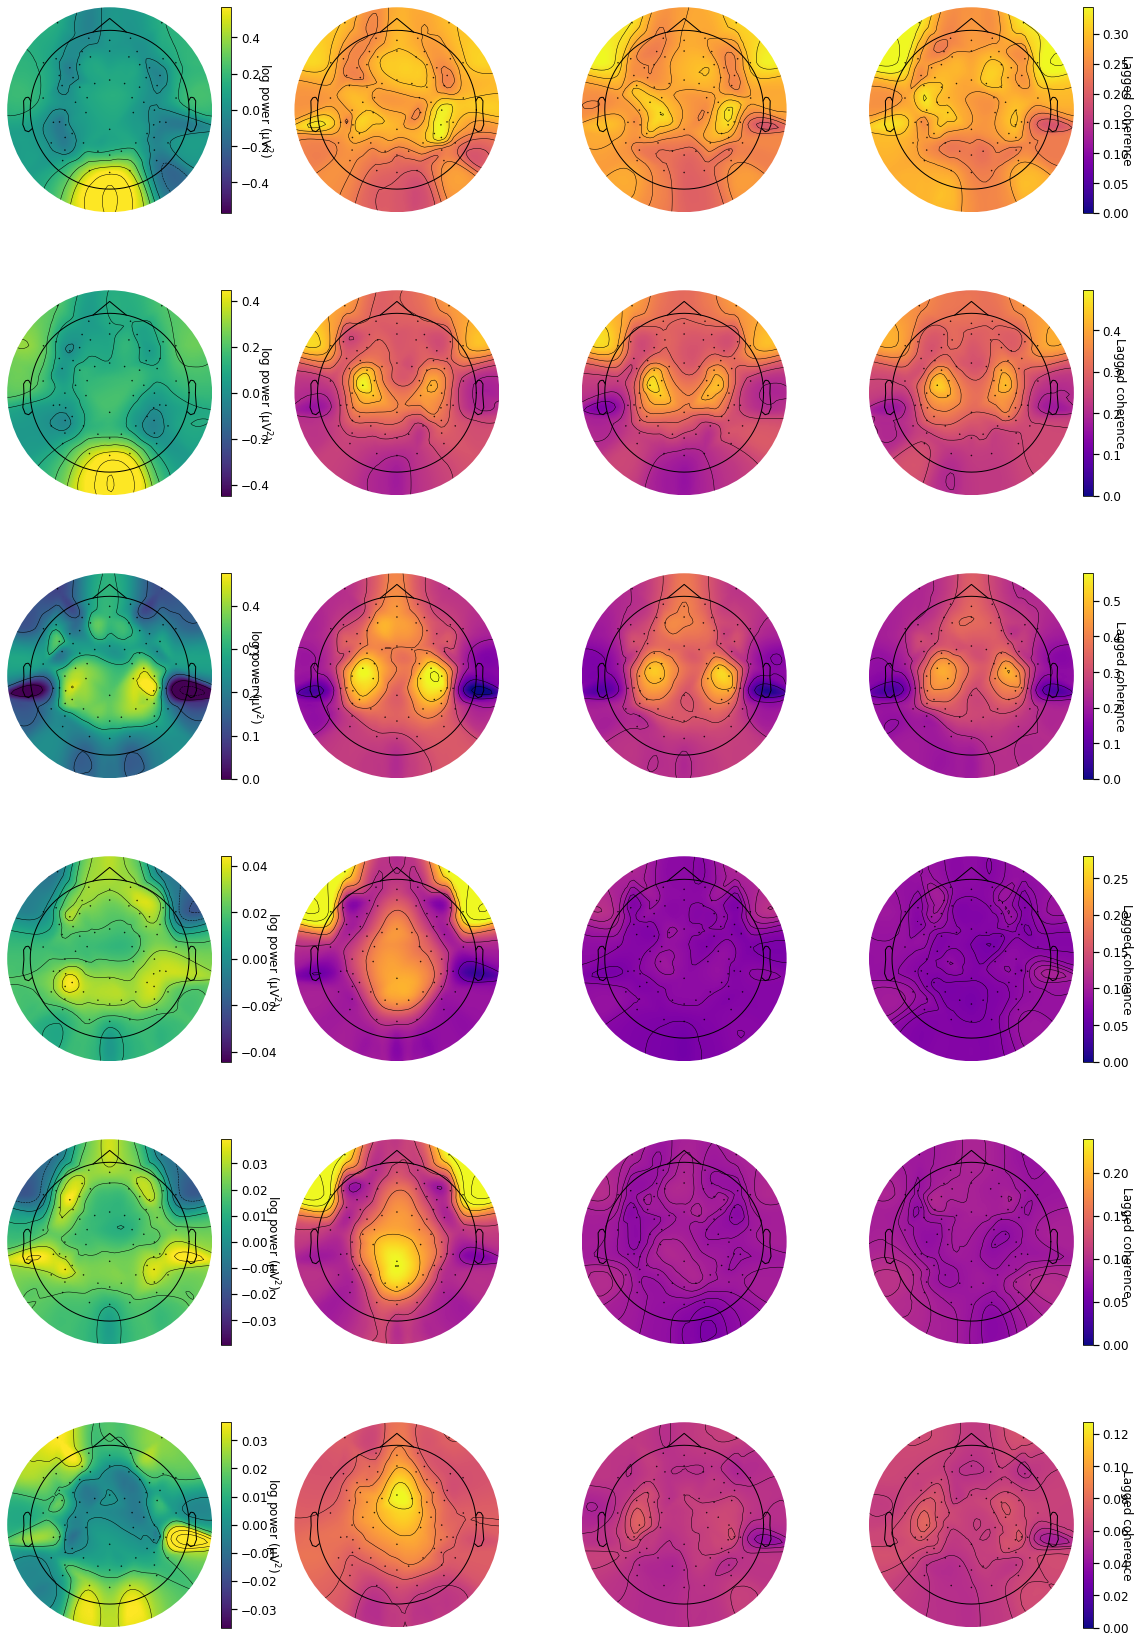

In [40]:
plt.rcParams.update({
    'font.size': 12,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

fig=plt.figure(figsize=(16,24), facecolor='w')
gs = fig.add_gridspec(len(ages)*2,4)

for age_idx, age in enumerate(ages):
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_C_fois.mat')
    f = scipy.io.loadmat(fname)
    all_fois=f['fois'][0]
    ranges=np.zeros((len(all_fois),2))
    for f_idx,foi in enumerate(all_fois):
        ranges[f_idx,:]=foi[0][0]
    ranges=ranges[ranges[:, 0].argsort()]
    mu_idx=np.where(ranges[:,1]<=13)[0][-1]
    mu_range=ranges[mu_idx,:]
    high_range=[40, 80]

    # Load PSD
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    periodic=f['periodic']
    frex=f['frex']
    frex_idx=np.where((frex>=mu_range[0]) & (frex<=mu_range[1]))[0]
    mean_mu=np.mean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)
    frex_idx=np.where((frex>=high_range[0]) & (frex<=high_range[1]))[0]
    mean_high=np.mean(np.nanmean(periodic[:,:,frex_idx],axis=2),axis=0)
    
    ax = fig.add_subplot(gs[age_idx, 0])
    tm,cm=plot_topomap(mean_mu,info,cmap='viridis',axes=ax,show=False)
    cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
    cbar.set_label('log power (µV$^2$)', rotation=270)

    ax = fig.add_subplot(gs[len(ages)+age_idx, 0])
    tm,cm=plot_topomap(mean_high,info,cmap='viridis',axes=ax,show=False)
    cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
    cbar.set_label('log power (µV$^2$)', rotation=270)

    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    lags=f['lags'][0,:]
    lagged_coh=f['lagged_coh']

    freq_idx=np.where((foi>=5) & (foi<=80))[0]
    foi=foi[freq_idx]
    lag_idx=np.where((lags<=4.5))[0]
    lags=lags[lag_idx]
    lagged_coh=lagged_coh[:,:,freq_idx,:]
    lagged_coh=lagged_coh[:,:,:,lag_idx]

    for s in range(lagged_coh.shape[0]):
        subj_lagged_coh=lagged_coh[s,:,:,:]
        lagged_coh[s,:,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])
    
    mu_foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
    high_foi_lc=np.zeros((lagged_coh.shape[0],len(plags),lagged_coh.shape[1]))
    for l in range(len(plags)):
        lag_idx=np.where((lags>=plags[l]) & (lags<=(plags[l]+.5)))[0]
        foi_idx=np.where((foi>=mu_range[0]) & (foi<=mu_range[1]))[0]
        flc=lagged_coh[:,:,foi_idx,:]
        flc=flc[:,:,:,lag_idx]
        flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
        mu_foi_lc[:,l,:]=flc
        
        foi_idx=np.where((foi>=high_range[0]) & (foi<=high_range[1]))[0]
        flc=lagged_coh[:,:,foi_idx,:]
        flc=flc[:,:,:,lag_idx]
        flc=np.squeeze(np.nanmean(np.nanmean(flc,axis=2),axis=2))
        high_foi_lc[:,l,:]=flc
    mean_mu_foi_lc=np.nanmean(mu_foi_lc,axis=0)
    mean_high_foi_lc=np.nanmean(high_foi_lc,axis=0)
        
    max_mu_lc=np.max(mean_mu_foi_lc[:])
    for l in range(len(plags)):
        ax = fig.add_subplot(gs[age_idx, l+1])
        tm,cm=plot_topomap(mean_mu_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=0, vmax=max_mu_lc)
        cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
        if l<len(plags)-1:
            fig.delaxes(cbar.ax)
    cbar.set_label('Lagged coherence', rotation=270)
    max_high_lc=np.max(mean_high_foi_lc[:])
    for l in range(len(plags)):
        ax = fig.add_subplot(gs[len(ages)+age_idx, l+1])
        tm,cm=plot_topomap(mean_high_foi_lc[l,:],info,cmap='plasma',axes=ax,show=False, vmin=0, vmax=max_high_lc)
        cbar=plt.colorbar(tm,fraction=0.046, pad=0.04)
        if l<len(plags)-1:
            fig.delaxes(cbar.ax)
    cbar.set_label('Lagged coherence', rotation=270)

plt.tight_layout()

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s3.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s3.png')